In [2]:
from pandas import *
from numpy import array
import glob
from skimage.color import rgb2gray
from scipy import misc
from numpy import asarray
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
path = "/home/thiago/Documentos/mitotic-index-calc/image_examples"

def get_all_image_names(path):
    filetypes = [".png", ".jpg", "jpeg", "tif", "tiff"]
    imlist = []
    for filetype in filetypes:
        imlist += glob.glob(path + "/*"+ filetype)
    return imlist

imlist = get_all_image_names(path)
print(len(imlist))


39


In [3]:
df = DataFrame(imlist, columns = ["Filename"])
df["photo"] = df.Filename.apply(lambda x: misc.imread(x))
df.shape

(39, 2)

In [4]:
def checksizephoto(photo): 
    if photo.shape[0] > 101 and photo.shape[1] > 101: return True
    else: return False

df = df[df.photo.apply(checksizephoto)]

In [5]:
df.head(3)
df.shape


(29, 2)

In [6]:
df["photoblue"] = df.photo.apply(lambda x : x[:,:,2])
df["photo"] = df.photo.apply(rgb2gray)

In [7]:
from skimage.feature import blob_dog
df["blobs"]= df.photoblue.apply(lambda x:blob_dog(x[56:-56,56:-56], min_sigma = 10, max_sigma = 30, threshold=.8))
df.head(3)

,Filename,photo,photoblue,blobs
10,/home/thiago/Documentos/mitotic-index-calc/ima...,"[[0.0120474509804, 0.0120474509804, 0.00895921...","[[4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","[[229.0, 708.0, 25.6]]"
11,/home/thiago/Documentos/mitotic-index-calc/ima...,"[[0.0145850980392, 0.0145850980392, 0.01458509...","[[6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 7, 7, 7, 7, 6,...","[[559.0, 540.0, 25.6], [659.0, 390.0, 25.6], [..."
12,/home/thiago/Documentos/mitotic-index-calc/ima...,"[[0.00814078431373, 0.00814078431373, 0.008974...","[[6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 5, 6, 6,...","[[361.0, 646.0, 25.6]]"


In [8]:
df.iloc[3]["blobs"] 

array([[ 272. ,  737. ,   25.6]])

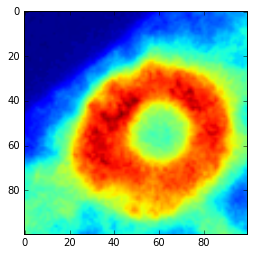

In [9]:
def CreateIndividualCellPatches(row):
    result = []
    for blob in row["blobs"]:
        y,x,r = blob
        y, x = int(y), int(x)
        result += [row["photo"][y:y+100,x:x+100]]
    return result

df["IndividualCellPatches"] = df.apply(CreateIndividualCellPatches, axis = 1)
plt.imshow(df.iloc[0]["IndividualCellPatches"][0])
plt.show()

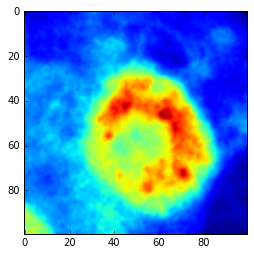

In [10]:
plt.imshow(df.iloc[5]["IndividualCellPatches"][1])
plt.show()

In [11]:
df.head(3)

,Filename,photo,photoblue,blobs,IndividualCellPatches
10,/home/thiago/Documentos/mitotic-index-calc/ima...,"[[0.0120474509804, 0.0120474509804, 0.00895921...","[[4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","[[229.0, 708.0, 25.6]]","[[[0.0112141176471, 0.0112141176471, 0.0120474..."
11,/home/thiago/Documentos/mitotic-index-calc/ima...,"[[0.0145850980392, 0.0145850980392, 0.01458509...","[[6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 7, 7, 7, 7, 6,...","[[559.0, 540.0, 25.6], [659.0, 390.0, 25.6], [...","[[[0.0247129411765, 0.0249956862745, 0.0249956..."
12,/home/thiago/Documentos/mitotic-index-calc/ima...,"[[0.00814078431373, 0.00814078431373, 0.008974...","[[6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 5, 6, 6,...","[[361.0, 646.0, 25.6]]","[[[0.0157309803922, 0.0151803921569, 0.0213568..."


In [12]:
import pickle
from Suvrellib import Suvrel
CLF = pickle.load(open("picklePy3Clf", "rb"))

In [13]:
from HOGnLBPfeatures import getLBP, getHoG, abs_pha_fft
def Get_all_features(image):
    return np.hstack([abs_pha_fft(image),getHoG(image), getLBP(image)])
df["Features4EachPatch"] =df.IndividualCellPatches.apply(lambda x : [Get_all_features(patch) for patch in x])

In [14]:
print(len(df.iloc[3]["Features4EachPatch"]))
print(len(df.iloc[3]["Features4EachPatch"][0]))


1
29700


In [15]:
def PredictPatch(PatchFeatures):
    return  CLF.predict(PatchFeatures.reshape(1,-1))
    
df["predict"] = df["Features4EachPatch"].apply(lambda x: array([PredictPatch(patchfeat) for patchfeat in x]).reshape(1,-1))

In [16]:
df["MitoticIndex"] = df.predict.apply(lambda x: "{0:.2f} ({1}|{2})".format(x.sum()/len(x[0]), x.sum(), len(x[0])- x.sum()))
df["Mitosis"] = df.predict.apply(lambda x : x.sum())
df["interfase"] = df.predict.apply(lambda x:  len(x[0])- x.sum())
df.head(5)

,Filename,photo,photoblue,blobs,IndividualCellPatches,Features4EachPatch,predict,MitoticIndex,Mitosis,interfase
10,/home/thiago/Documentos/mitotic-index-calc/ima...,"[[0.0120474509804, 0.0120474509804, 0.00895921...","[[4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","[[229.0, 708.0, 25.6]]","[[[0.0112141176471, 0.0112141176471, 0.0120474...","[[1138.06074471, 197.660132802, 98.6299803352,...",[[0]],0.00 (0|1),0.0,1.0
11,/home/thiago/Documentos/mitotic-index-calc/ima...,"[[0.0145850980392, 0.0145850980392, 0.01458509...","[[6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 7, 7, 7, 7, 6,...","[[559.0, 540.0, 25.6], [659.0, 390.0, 25.6], [...","[[[0.0247129411765, 0.0249956862745, 0.0249956...","[[1072.09631059, 282.585455989, 5.32825965878,...","[[0, 0, 0, 0, 0]]",0.00 (0|5),0.0,5.0
12,/home/thiago/Documentos/mitotic-index-calc/ima...,"[[0.00814078431373, 0.00814078431373, 0.008974...","[[6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 5, 6, 6,...","[[361.0, 646.0, 25.6]]","[[[0.0157309803922, 0.0151803921569, 0.0213568...","[[1080.5382698, 310.059945892, 34.9479826279, ...",[[1]],1.00 (1|0),1.0,0.0
13,/home/thiago/Documentos/mitotic-index-calc/ima...,"[[0.0120474509804, 0.0117647058824, 0.01176470...","[[4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,...","[[272.0, 737.0, 25.6]]","[[[0.052208627451, 0.052491372549, 0.052491372...","[[1128.55997294, 362.616733675, 103.97658441, ...",[[1]],1.00 (1|0),1.0,0.0
14,/home/thiago/Documentos/mitotic-index-calc/ima...,"[[0.00895921568627, 0.00924196078431, 0.012047...","[[3, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4,...","[[269.0, 167.0, 25.6], [450.0, 975.0, 25.6], [...","[[[0.0617709803922, 0.0690635294118, 0.0690635...","[[1569.82591608, 153.506603199, 92.8159180578,...","[[0, 0, 1, 0]]",0.25 (1|3),1.0,3.0


In [17]:
a = df.Mitosis.values.sum()
b = df.interfase.values.sum()
print("the mitotic index is {0:.2f}, with {1} of {2} cell on mitosis".format(a/(a+b) ,a,a+b))

the mitotic index is 0.73, with 67.0 of 92.0 cell on mitosis
